# Decision-making systems in medicine (Sistemi odlucivanja u medicini SOM 13E053SOM) 
## Project prediction of Arrhythmia (data set from https://archive.ics.uci.edu/ml/datasets/Arrhythmia)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Dataset analysis

In [2]:
data = pd.read_csv('01_arrhythmia_dataset.csv')
data.head(10)

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7
5,13,0,169,51,100,167,321,174,91,107,...,-0.6,12.2,-2.8,0.0,0,0.9,2.2,13.5,31.1,14
6,40,1,160,52,77,129,377,133,77,77,...,0.0,6.5,0.0,0.0,0,0.4,1.0,14.3,20.5,1
7,49,1,162,54,78,0,376,157,70,67,...,0.0,8.2,-1.9,0.0,0,0.1,0.5,15.8,19.8,1
8,44,0,168,56,84,118,354,160,63,61,...,0.0,7.0,-1.3,0.0,0,0.6,2.1,12.5,30.9,1
9,50,1,167,67,89,130,383,156,73,85,...,-0.6,10.8,-1.7,0.0,0,0.8,0.9,20.1,25.1,10


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to diagnosis
dtypes: float64(116), int64(159), object(5)
memory usage: 988.9+ KB


In [4]:
# Quick check only for columns 10-14
print("\n" + "="*60)
print("QUICK CHECK: COLUMNS 10-14 (VECTOR ANGLES)")
print("="*60)

for col_idx in range(10, 15):
    col = data.iloc[:, col_idx]
    print(f"\nColumn {col_idx}:")
    print(f"  Type: {col.dtype}")
    
    if col.dtype == 'object':
        print(f"  Contains '?': {(col == '?').sum()}")
        print(f"  Sample values: {col.head(10).tolist()}")
    else:
        print(f"  Min: {col.min()}, Max: {col.max()}")
        print(f"  NaN count: {col.isna().sum()}")

print("="*60)
print("ANALYSIS OF INVALID VALUES")
print("="*60)


QUICK CHECK: COLUMNS 10-14 (VECTOR ANGLES)

Column 10:
  Type: object
  Contains '?': 8
  Sample values: ['13', '37', '34', '11', '13', '66', '49', '7', '69', '34']

Column 11:
  Type: object
  Contains '?': 22
  Sample values: ['64', '-17', '70', '-5', '61', '52', '75', '8', '78', '70']

Column 12:
  Type: object
  Contains '?': 1
  Sample values: ['-2', '31', '66', '20', '3', '88', '65', '51', '66', '71']

Column 13:
  Type: object
  Contains '?': 376
  Sample values: ['?', '?', '23', '?', '?', '?', '?', '?', '84', '?']

Column 14:
  Type: object
  Contains '?': 1
  Sample values: ['63', '53', '75', '71', '?', '84', '70', '67', '64', '63']
ANALYSIS OF INVALID VALUES


### Problem Analysis

- **Column 10 (index 10):** 8 `'?'` values – *small*, fill with median  
- **Column 11 (index 11):** 22 `'?'` values – *small*, fill with median  
- **Column 12 (index 12):** 1 `'?'` value – *negligible*, fill with median  
- **Column 13 (index 13):** 376 `'?'` values – **HUGE** (almost 84%!)  
- **Column 14 (index 14):** 1 `'?'` value – *negligible*, fill with median



### Strategy

- **Column 13 – REMOVE!** (376/452 = 83% missing!)  
  A column with over 50% missing values is useless and should be dropped.  
- **Other columns – FILL with median**

In [5]:
# Create clean copy
data_clean = data.copy()

# 1. CHECK COLUMN 13 (index 13) - J angle
col_13 = data_clean.iloc[:, 13]
qm_count_13 = (col_13 == '?').sum()
total_rows = len(data_clean)
missing_percent_13 = (qm_count_13 / total_rows) * 100

print(f"\nColumn 13 (index 13) - J angle:")
print(f"'?' values: {qm_count_13}/{total_rows} ({missing_percent_13:.1f}%)")

if missing_percent_13 > 50:
    print(f"DECISION: DROP this column (>50% missing)")
    print(f"Reason: Too many missing values make this attribute unreliable")
    
    # Drop column 13
    data_clean = data_clean.drop(data_clean.columns[13], axis=1)
    print(f"Column 13 removed")
    print(f"New shape: {data_clean.shape}")
else:
    print(f"DECISION: KEEP and fill with median")

# 2. CLEAN REMAINING COLUMNS (10, 11, 12, 14)
# Note: After dropping column 13, column 14 becomes column 13!

print(f"\n{'='*60}")
print("PROCESSING OTHER COLUMNS:")
print("-"*60)

# Columns to process (adjust indices if column 13 was dropped)
if missing_percent_13 > 50:
    # Column 13 was dropped, so now we have:
    # Old index 10 → still 10
    # Old index 11 → still 11  
    # Old index 12 → still 12
    # Old index 14 → now 13!
    columns_to_clean = [10, 11, 12, 13]  # adjusted indices
else:
    columns_to_clean = [10, 11, 12, 13, 14]

for col_idx in columns_to_clean:
    if col_idx < len(data_clean.columns) - 1:  # Don't touch target column
        col_name = data_clean.columns[col_idx]
        col = data_clean[col_name]
        
        print(f"\nColumn index {col_idx}:")
        
        # Count '?' before
        qm_before = (col == '?').sum() if col.dtype == 'object' else 0
        print(f"   '?' values before: {qm_before}")
        
        # Step 1: Replace '?' with NaN
        data_clean[col_name] = data_clean[col_name].replace('?', np.nan)
        
        # Step 2: Convert to numeric
        data_clean[col_name] = pd.to_numeric(data_clean[col_name], errors='coerce')
        
        # Step 3: Fill NaN with median
        if data_clean[col_name].isna().any():
            median_val = data_clean[col_name].median()
            nan_count = data_clean[col_name].isna().sum()
            data_clean[col_name].fillna(median_val, inplace=True)
            
            print(f"Replaced {nan_count} missing values with median: {median_val:.2f}")
            print(f"New type: {data_clean[col_name].dtype}")
        else:
            print(f"No missing values")

# 3. FINAL VERIFICATION
print(f"\n{'='*60}")
print("FINAL VERIFICATION:")
print("-"*60)

print(f"Original shape: {data.shape}")
print(f"New shape: {data_clean.shape}")
print(f"Columns removed: {data.shape[1] - data_clean.shape[1]}")

# Check for remaining '?' or NaN
total_nan = data_clean.isna().sum().sum()
print(f"Total NaN remaining: {total_nan}")

# Check data types
print(f"\nData type summary:")
print(data_clean.dtypes.value_counts())

# Save cleaned data
data_clean.to_csv('data_cleaned_columns_10_14.csv', index=False)
print(f"\nCleaned data saved to 'data_cleaned_columns_10_14.csv'")

print(f"\n{'='*60}")
print("SUMMARY OF ACTIONS:")
print("-"*60)
print(f"Column 13 (J angle): REMOVED (83% missing)")
print(f"Column 10 (T angle): Filled 8 missing values with median")
print(f"Column 11 (P angle): Filled 22 missing values with median")
print(f"Column 12 (QRST angle): Filled 1 missing value with median")
print(f"Column 14 (Heart rate): Filled 1 missing value with median")
print(f"All columns converted to numeric type")
print("="*60)


Column 13 (index 13) - J angle:
'?' values: 376/452 (83.2%)
DECISION: DROP this column (>50% missing)
Reason: Too many missing values make this attribute unreliable
Column 13 removed
New shape: (452, 279)

PROCESSING OTHER COLUMNS:
------------------------------------------------------------

Column index 10:
   '?' values before: 8
Replaced 8 missing values with median: 41.00
New type: float64

Column index 11:
   '?' values before: 22
Replaced 22 missing values with median: 56.00
New type: float64

Column index 12:
   '?' values before: 1
Replaced 1 missing values with median: 40.00
New type: float64

Column index 13:
   '?' values before: 1
Replaced 1 missing values with median: 72.00
New type: float64

FINAL VERIFICATION:
------------------------------------------------------------
Original shape: (452, 280)
New shape: (452, 279)
Columns removed: 1
Total NaN remaining: 0

Data type summary:
int64      159
float64    120
Name: count, dtype: int64

Cleaned data saved to 'data_cleane

In [6]:
# Define columns according to documentation
col_names = {
    0: 'Age',
    1: 'Sex', 
    2: 'Height',
    3: 'Weight',
    4: 'QRS_duration',
    5: 'PR_interval',
    6: 'QT_interval',
    7: 'T_interval',
    8: 'P_interval',
    13: 'Heart_rate'
}

# 1. CHECK BASIC BIOMETRIC DATA
print("\nBIOMETRIC DATA:")
print("-"*60)

# Age (0-120 years is realistic)
age_col = data_clean.iloc[:, 0]
print(f"\nAGE (column 0):")
print(f"   Min: {age_col.min()}, Max: {age_col.max()}")
print(f"   Mean: {age_col.mean():.1f}, Std: {age_col.std():.1f}")

invalid_age = data_clean[(age_col < 0) | (age_col > 120)]
if len(invalid_age) > 0:
    print(f"Found {len(invalid_age)} invalid values!")
    print(f"   Values: {age_col[invalid_age.index].tolist()}")
else:
    print(f"All values are in valid range (0-120)")

# Sex (0 or 1)
sex_col = data_clean.iloc[:, 1]
print(f"\nSEX (column 1):")
print(f"   Unique values: {sex_col.unique()}")
invalid_sex = data[~sex_col.isin([0, 1])]
if len(invalid_sex) > 0:
    print(f"Found {len(invalid_sex)} invalid values!")
else:
    print(f"All values are valid (0 or 1)")

# Height (100-250 cm is realistic)
height_col = data_clean.iloc[:, 2]
print(f"\nHEIGHT (column 2):")
print(f"   Min: {height_col.min()}, Max: {height_col.max()}")
print(f"   Mean: {height_col.mean():.1f}, Std: {height_col.std():.1f}")

invalid_height = data_clean[(height_col < 100) | (height_col > 250)]
if len(invalid_height) > 0:
    print(f"Found {len(invalid_height)} invalid values!")
    print(f"   Values: {height_col[invalid_height.index].tolist()}")
else:
    print(f"All values are in valid range (100-250 cm)")
    
# Weight (30-200 kg is realistic)
weight_col = data_clean.iloc[:, 3]
print(f"\nWEIGHT (column 3):")
print(f"   Min: {weight_col.min()}, Max: {weight_col.max()}")
print(f"   Mean: {weight_col.mean():.1f}, Std: {weight_col.std():.1f}")

invalid_weight = data_clean[(weight_col < 4) | (weight_col > 200)]
if len(invalid_weight) > 0:
    print(f"Found {len(invalid_weight)} invalid values!")
    print(f"   Values: {weight_col[invalid_weight.index].tolist()}")
else:
    print(f"All values are in valid range (4-200 kg)")

# Heart rate (30-220 beats/min is realistic)
hr_col = data_clean.iloc[:, 13]
print(f"\nHEART RATE (column 13):")
print(f"   Min: {hr_col.min()}, Max: {hr_col.max()}")
print(f"   Mean: {hr_col.mean():.1f}, Std: {hr_col.std():.1f}")

invalid_hr = data_clean[(hr_col < 30) | (hr_col > 220)]
if len(invalid_hr) > 0:
    print(f"Found {len(invalid_hr)} invalid values!")
    print(f"   Values: {hr_col[invalid_hr.index].tolist()}")
else:
    print(f"All values are in valid range (30-220 bpm)")    


BIOMETRIC DATA:
------------------------------------------------------------

AGE (column 0):
   Min: 0, Max: 83
   Mean: 46.5, Std: 16.5
All values are in valid range (0-120)

SEX (column 1):
   Unique values: [0 1]
All values are valid (0 or 1)

HEIGHT (column 2):
   Min: 105, Max: 780
   Mean: 166.2, Std: 37.2
Found 2 invalid values!
   Values: [780, 608]

WEIGHT (column 3):
   Min: 6, Max: 176
   Mean: 68.2, Std: 16.6
All values are in valid range (4-200 kg)

HEART RATE (column 13):
   Min: 44.0, Max: 163.0
   Mean: 74.5, Std: 13.9
All values are in valid range (30-220 bpm)


In [7]:
# Last column is diagnosis (class)
target_col = data_clean.columns[-1]

print("="*60)
print("PROCESSING MINORITY CLASSES")
print("="*60)

# 1. Originalna distribucija
print("\nORIGINAL DISTRIBUTION:")
print("-"*60)

total_instances = len(data_clean)
class_counts = data[target_col].value_counts().sort_index()

for cls in sorted(data_clean[target_col].unique()):
    count = class_counts[cls]
    percent = (count / total_instances) * 100
    print(f"Class {cls:2d}: {count:3d} instances ({percent:5.2f}%)")

# 2. Identify minority classes (< 3%)
minority_threshold = 3.0

print(f"\n{'='*60}")
print(f"MINORITY CLASSES (< {minority_threshold}%):")
print("-"*60)

minority_classes = []
for cls in sorted(data_clean[target_col].unique()):
    count = class_counts[cls]
    percent = (count / total_instances) * 100
    
    if percent < minority_threshold and cls != 16:  # NE diraj klasu 16 (već je Others)
        minority_classes.append(cls)
        print(f"Class {cls:2d}: {count:3d} instanci ({percent:5.2f}%) → TRANSFERS TO 16")

print(f"\nTotal minority classes: {len(minority_classes)}")

# 3. Unite minority classes to 16 (Others)
print(f"\n{'='*60}")
print("UNITE MINORITY CLASSES TO 16 (Others):")
print("-"*60)

# Transfer all minority classes to 16
total_moved = 0
for cls in minority_classes:
    count = (data_clean[target_col] == cls).sum()
    data_clean.loc[data_clean[target_col] == cls, target_col] = 16
    total_moved += count
    print(f"Class {cls:2d} → 16: {count} insstances")

print(f"\nTotal instances transfered: {total_moved}")

# 4. New distribution
print(f"\n{'='*60}")
print("NEW DISTRIBUTION (after uniting):")
print("-"*60)

final_counts = data_clean[target_col].value_counts().sort_index()

for cls in sorted(data_clean[target_col].unique()):
    count = final_counts[cls]
    percent = (count / len(data_clean)) * 100
    
    if cls == 16:
        print(f"Class {cls:2d} (Others): {count:3d} instances ({percent:5.2f}%) ")
    else:
        print(f"Class {cls:2d}: {count:3d} instances ({percent:5.2f}%)")

print(f"\n{'='*60}")
print(f"FINAL RESULT:")
print("-"*60)
print(f"Original number of classes: {data[target_col].nunique()}")
print(f"Final number of classes: {data_clean[target_col].nunique()}")
print(f"Reduction: {data[target_col].nunique() - data_clean[target_col].nunique()} klasa")
print(f"\nFinal classes: {sorted(data_clean[target_col].unique())}")

# 5. Save clean data
data_clean.to_csv('data_clean_final.csv', index=False)
print(f"\nSaved to 'data_final.csv'")
data_clean_final = data_clean

PROCESSING MINORITY CLASSES

ORIGINAL DISTRIBUTION:
------------------------------------------------------------
Class  1: 245 instances (54.20%)
Class  2:  44 instances ( 9.73%)
Class  3:  15 instances ( 3.32%)
Class  4:  15 instances ( 3.32%)
Class  5:  13 instances ( 2.88%)
Class  6:  25 instances ( 5.53%)
Class  7:   3 instances ( 0.66%)
Class  8:   2 instances ( 0.44%)
Class  9:   9 instances ( 1.99%)
Class 10:  50 instances (11.06%)
Class 14:   4 instances ( 0.88%)
Class 15:   5 instances ( 1.11%)
Class 16:  22 instances ( 4.87%)

MINORITY CLASSES (< 3.0%):
------------------------------------------------------------
Class  5:  13 instanci ( 2.88%) → TRANSFERS TO 16
Class  7:   3 instanci ( 0.66%) → TRANSFERS TO 16
Class  8:   2 instanci ( 0.44%) → TRANSFERS TO 16
Class  9:   9 instanci ( 1.99%) → TRANSFERS TO 16
Class 14:   4 instanci ( 0.88%) → TRANSFERS TO 16
Class 15:   5 instanci ( 1.11%) → TRANSFERS TO 16

Total minority classes: 6

UNITE MINORITY CLASSES TO 16 (Others):
--

## 2) Feature selection

In [8]:
def calculateInfoD(col):
    un = np.unique(col)
    infoD = 0
    for u in un:
        p = sum(col == u)/len(col)
        infoD -= p*np.log2(p)
    return infoD

In [9]:
def informationGain(feat):
    numberOfSteps = 10
    classes = data_clean_final.iloc[:, -1]
    infoD = calculateInfoD(classes)
    
    col = data_clean_final.iloc[:, feat]
    f = np.unique(col)
    
    if len(f) > numberOfSteps:
            step = (max(col) - min(col))/numberOfSteps
            col = np.floor(col/step)*step
            f = np.unique(col)
                
    infoDA = 0
    for i in f:
        mask = (col == i).values 
        temp = classes.iloc[mask]
    
        infoDi = calculateInfoD(temp)
        Di = sum(mask)
        D = len(col)

        infoDA += Di*infoDi/D
        
    return infoD - infoDA
            
    

In [10]:
# Calculate average Information Gain for each column
# Each column's IG is measured against all other columns


columns = data_clean_final.columns
n_cols = len(columns)

# Store IG for each column
info_gains = []

for col in range(data_clean_final.shape[1]-1):
    
    # Calculate IG
    info_gains.append(informationGain(col))

# Create results dataframe
feature_importance = pd.DataFrame({
    'Index': range(len(info_gains)),  # Column index
    'Column': columns[:-1],
    'Average_Information_Gain': info_gains
}).sort_values(by='Average_Information_Gain', ascending=False)

# Select top 10
top_10 = feature_importance.head(10)

print("TOP 10 COLUMNS BY AVERAGE INFORMATION GAIN:")
print("=" * 60)
print(top_10.to_string(index=False))
print("\n")

# Print just the column names
print("\nSELECTED COLUMN NAMES:")
print(top_10['Column'].tolist())

TOP 10 COLUMNS BY AVERAGE INFORMATION GAIN:
 Index     Column  Average_Information_Gain
    13 heart_rate                  0.347994
   241         JR                  0.331186
   275         LE                  0.314144
   112         EB                  0.310474
    10          T                  0.300626
   175         GU                  0.295567
   195         HR                  0.291330
   265         KS                  0.288737
   100         DM                  0.288149
    88         DA                  0.273138



SELECTED COLUMN NAMES:
['heart_rate', 'JR', 'LE', 'EB', 'T', 'GU', 'HR', 'KS', 'DM', 'DA']


In [11]:
wanted_col = top_10['Column'].values
wanted_col = np.append(wanted_col, data_clean_final.columns[-1])

# Save final data
data_final = data_clean_final[wanted_col]
data_final.head(10)

data_final.to_csv('data_final.csv', index=False)
print(f"Saved to 'data_final.csv'")


Saved to 'data_final.csv'


### Calculate spearman correlation

In [12]:
def calculate_rank(data):
    ranked_data = np.zeros(data.shape)
    sorted_data = sorted(data)

    val, cnt = np.unique(sorted_data, return_counts = True)

    r = 1
    for i in range(len(val)):
        rank = np.mean(np.arange(r, r+cnt[i]))
        pos = np.where(data == val[i])
        ranked_data[pos] = rank
        
        r += cnt[i]
        
    return ranked_data

In [13]:
def spearman_correlation(x, y):
    rank_x = calculate_rank(x)
    rank_y = calculate_rank(y)

    spearman = np.cov(rank_x, rank_y)[0,1]/np.std(rank_x)/np.std(rank_y)

    return spearman
    

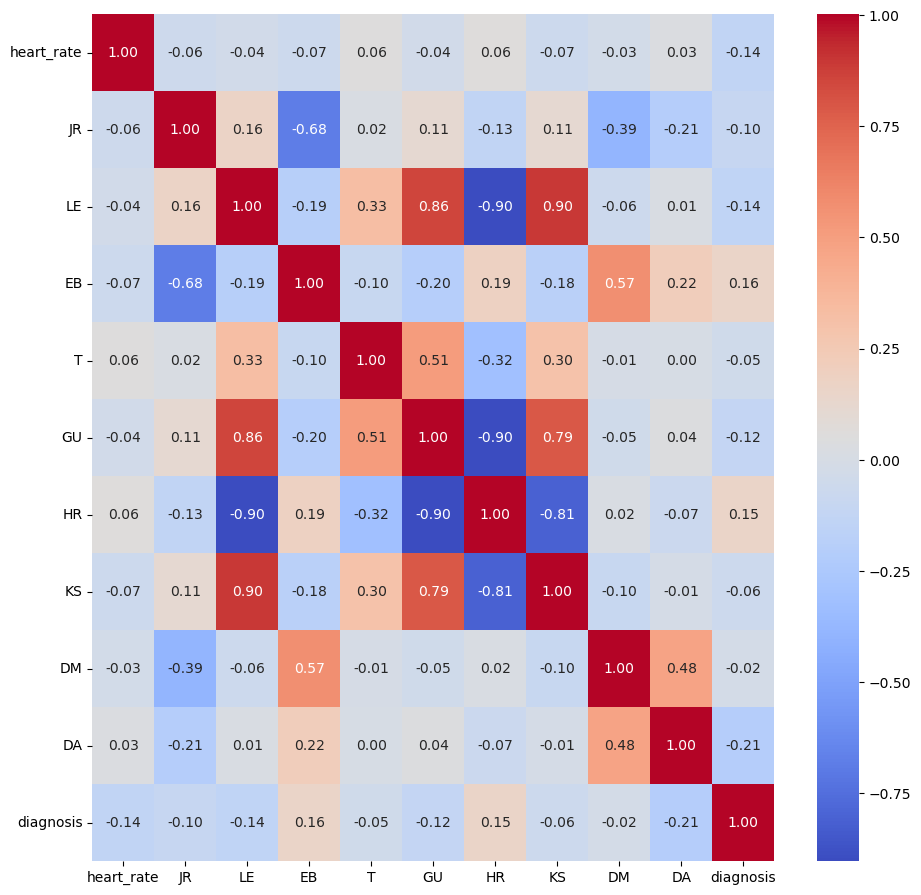

In [14]:
# Get column names
cols = data_final.columns
n = len(cols)

# Create an empty correlation matrix
corr_matrix = np.zeros((n, n))

# Fill the correlation matrix
for i in range(n):
    for j in range(n):
        corr_matrix[i, j] = spearman_correlation(data[cols[i]], data[cols[j]])

# Convert to DataFrame for better display
corr_df = pd.DataFrame(corr_matrix, index=cols, columns=cols)
#print(corr_df)

plt.figure(figsize=(11, 11))
sns.heatmap(corr_df, annot = True, fmt='.2f',cmap='coolwarm')
plt.yticks(rotation=0)
plt.show()

Top 2 features most correlated with class: ['DA', 'EB']


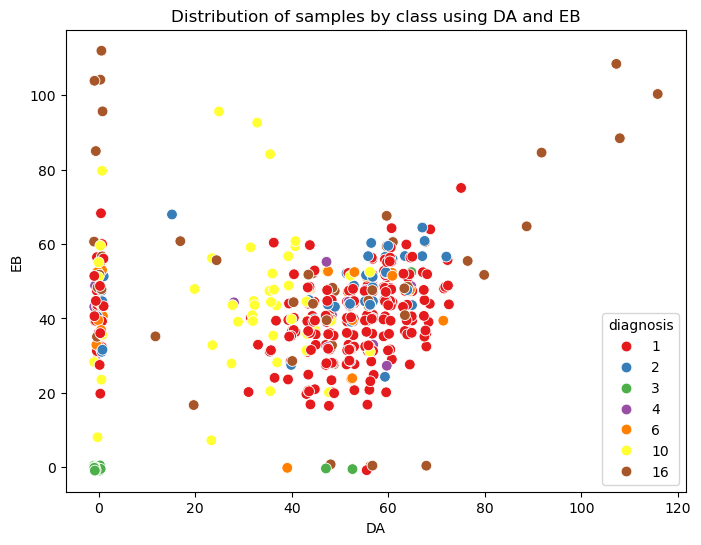

In [15]:
# 1. Identify the top 2 features most correlated with the class
class_corr = corr_df['diagnosis'].drop('diagnosis')  # exclude correlation of class with itself

# Take the two features with the highest absolute correlation
top2_features = class_corr.abs().sort_values(ascending=False).head(2).index.tolist()
print("Top 2 features most correlated with class:", top2_features)


# 2. Create scatter plot of samples colored by class using these two features
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=data_final,
    x=data_final[top2_features[0]] + np.random.uniform(-1, 1, size=len(data_final)),
    y=data_final[top2_features[1]] + np.random.uniform(-1, 1, size=len(data_final)),
    hue='diagnosis',           # color by class
    palette='Set1',
    s=60                   # marker size
)
plt.title(f"Distribution of samples by class using {top2_features[0]} and {top2_features[1]}")
plt.show()

## 3) Dimension reduction (LDA tranformation)

In [16]:
def parameters(X, y, Class):
    # p = prior probability (n_class / n_total)
    # M = mean vector for class c (shape: n_features x 1)
    # S = covariance matrix for class c (shape: n_features x n_features)
    Xk = X.loc[y==Class, :]
    p = Xk.shape[0]/X.shape[0]
    M = Xk.mean().values.reshape(Xk.shape[1],1)
    S = Xk.cov()

    return (p, M, S)

In [17]:
def standardize(X):
    # Calculate mean and std for each feature
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # Avoid division by zero (if std=0, keep original values)
    std[std == 0] = 1
    
    # Standardize: (X - mean) / std
    X_scaled = (X - mean) / std
    
    return X_scaled, mean, std

In [18]:
import scipy.linalg

# Get unique classes
X = data_clean_final.iloc[:, :-1]
X_scaled, X_mean, X_std = standardize(X)
X_scaled.to_csv('input_data_standardized.csv', index=False)
print(f"Saved to 'input_data_standardized.csv'")

y = data_clean_final['diagnosis'].values
classes = np.unique(y)
n_features = X.shape[1]
n_samples = X.shape[0]

# Initialize scatter matrices
Sw = np.zeros((n_features, n_features))  # Within-class scatter matrix
Sb = np.zeros((n_features, n_features))  # Between-class scatter matrix

# Calculate overall mean
overall_mean = X_scaled.mean(axis=0).values.reshape(n_features, 1)

print("Calculating scatter matrices for each class...")

# Loop through each class
for c in classes:
    # Get parameters for this class
    p, M, S = parameters(X_scaled, y, c)
    
    # Within-class scatter:
    Sw += p * S
    
    # Between-class scatter:
    mean_diff = M - overall_mean
    Sb += p * (mean_diff @ mean_diff.T)
    
    print(f"  Class {c}: p={p:.4f}, processed")

print("\nScatter matrices calculated!")
print(f" Sw shape: {Sw.shape}")
print(f" Sb shape: {Sb.shape}")

S = np.linalg.pinv(Sw)@Sb
eigval, eigvec = np.linalg.eig(S)




Saved to 'input_data_standardized.csv'
Calculating scatter matrices for each class...
  Class 1: p=0.5420, processed
  Class 2: p=0.0973, processed
  Class 3: p=0.0332, processed
  Class 4: p=0.0332, processed
  Class 6: p=0.0553, processed
  Class 10: p=0.1106, processed
  Class 16: p=0.1283, processed

Scatter matrices calculated!
 Sw shape: (278, 278)
 Sb shape: (278, 278)


In [19]:
print("=" * 70)
print("EIGENVALUES AND EIGENVECTORS")
print("=" * 70)

# Sort eigenvalues and eigenvectors in descending order
idx = eigval.argsort()[::-1]  # Descending order indices
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]

# Filter out zero eigenvalues (keep only non-zero ones)
threshold = 1e-10
non_zero_idx = np.abs(eigval) > threshold
eigval_nonzero = eigval[non_zero_idx]
eigvec_nonzero = eigvec[:, non_zero_idx]

eigvec_nonzero = np.real(eigvec_nonzero)
eigval_nonzero = np.real(eigval_nonzero)

print("NON-ZERO EIGENVALUES")

print(f"\nNumber of non-zero eigenvalues: {len(eigval_nonzero)}")

for i, val in enumerate(eigval_nonzero):
    print(f"λ_{i+1} = {val:.6f}")

# Calculate explained variance ratio
total_variance = np.sum(eigval_nonzero) 
explained_variance = eigval_nonzero / total_variance
cumulative_variance = np.cumsum(explained_variance)

# Find minimum components for 80% variance
threshold_pct = 0.80
min_components = np.argmax(cumulative_variance >= threshold_pct) + 1

print(f"\n{'=' * 70}")
print(f"RESULT: Minimum components for >{threshold_pct*100:.0f}% variance: {min_components}")
print(f"Cumulative variance: {cumulative_variance[min_components-1]*100:.2f}%")
print(f"{'=' * 70}")

EIGENVALUES AND EIGENVECTORS
NON-ZERO EIGENVALUES

Number of non-zero eigenvalues: 6
λ_1 = 15.016668
λ_2 = 4.774613
λ_3 = 4.581791
λ_4 = 3.409449
λ_5 = 2.460254
λ_6 = 1.495388

RESULT: Minimum components for >80% variance: 4
Cumulative variance: 87.54%


In [20]:
# Transform data to 4 dimensions
n_components = 4
W = eigvec_nonzero[:, :n_components]  # First 4 eigenvectors

X_scaled_array = X_scaled.values

X_lda = X_scaled_array @ W  # Transform data

print(f"Original data shape: {X_scaled.shape}")
print(f"Transformed data shape: {X_lda.shape}")

# Create DataFrame with transformed data
lda_columns = [f'LDA_{i+1}' for i in range(n_components)]
data_lda_transformed = pd.DataFrame(X_lda, columns=lda_columns)
data_lda_transformed['diagnosis'] = y

print("\nTransformed dataset ready for classification!")
print(data_lda_transformed.head())

Original data shape: (452, 278)
Transformed data shape: (452, 4)

Transformed dataset ready for classification!
      LDA_1     LDA_2     LDA_3     LDA_4  diagnosis
0 -0.004975 -0.030809 -0.045791  0.041848         16
1 -0.014582 -0.024540 -0.065829 -0.032174          6
2 -0.015052  0.467929  0.068795  0.028549         10
3  0.000653  0.051282 -0.094516 -0.005588          1
4 -0.001020 -0.038058 -0.069379  0.003080         16


## 4) Hypothesis testing and parametric classification

In [21]:
# Get pdf for 4 features
def get_pdf(x, m, s):
    det = np.linalg.det(s)
    inv = np.linalg.inv(s)
    x_mu = x - m

    pdf_const = 1/np.sqrt(det)/(np.sqrt(2*np.pi))^4
    pdf_rest = np.exp(-0.5 * x_mu.T@inv@x_mu)[0,0]
    return pdf_const*pdf_rest



In [22]:
print("=" * 80)
print("PARAMETRIC CLASSIFICATION")
print("=" * 80)

# Prepare data
X = data_lda_transformed[['LDA_1', 'LDA_2', 'LDA_3', 'LDA_4']].values
y = data_lda_transformed['diagnosis'].values

print(f"\nTotal samples: {len(X)}")
print(f"Number of classes: {len(np.unique(y))}")

classes = np.unique(y)
class_params = {}

for c in classes:
    X_c = X[y == c]
    n_c = len(X_c)
    
    mean = np.mean(X_c, axis=0)
    cov = np.cov(X_c, rowvar=False) + np.eye(X.shape[1]) * 1e-6
    prior = n_c / len(y)
    
    class_params[c] = {'mean': mean, 'cov': cov, 'prior': prior, 'n': n_c}



PARAMETRIC CLASSIFICATION

Total samples: 452
Number of classes: 7


In [23]:
def classify_bayes(x, class_params, classes):
    #Classify using Bayes' theorem.
    likelihoods = {}
    
    # Calculate likelihood p(x|C) for each class
    for c in classes:
        likelihoods[c] = multivariate_normal.pdf(
            x, mean=class_params[c]['mean'], cov=class_params[c]['cov']
        )
    
    # Calculate evidence p(x)
    evidence = sum(likelihoods[c] * class_params[c]['prior'] for c in classes)
    if evidence == 0:
        evidence = 1e-10
    
    # Calculate posterior P(C|x)
    posteriors = {c: (likelihoods[c] * class_params[c]['prior']) / evidence 
                  for c in classes}
    
    pred_class = max(posteriors, key=posteriors.get)
    return pred_class, likelihoods, posteriors

In [24]:
from scipy.stats import multivariate_normal

# Show example for first sample
sample_idx = 0
test_sample = X[sample_idx]
true_class = y[sample_idx]

pred_class, likelihoods, posteriors = classify_bayes(test_sample, class_params, classes)

print(f"\nSample index: {sample_idx}")
print(f"Feature values: {test_sample}")
print(f"True class: {true_class}")

print(f"\n{'Class':<8} {'A Priori':<15} {'Likelihood':<20} {'A Posteriori':<15}")
print("-" * 80)
for c in sorted(classes):
    print(f"{c:<8} {class_params[c]['prior']:<15.6f} "
          f"{likelihoods[c]:<20.10e} {posteriors[c]:<15.6f}")
print("-" * 80)

print(f"\n✓ Predicted class: {pred_class}")
print(f"  True class: {true_class}")
print(f"  Classification: {'CORRECT ✓' if pred_class == true_class else 'INCORRECT ✗'}")
print(f"\n  Verification: Σ P(C|x) = {sum(posteriors.values()):.6f} (should be ≈ 1.0)")


Sample index: 0
Feature values: [-0.00497506 -0.03080912 -0.04579078  0.04184817]
True class: 16

Class    A Priori        Likelihood           A Posteriori   
--------------------------------------------------------------------------------
1        0.542035        2.5565310938e+01     0.001844       
2        0.097345        1.1211126057e+04     0.145238       
3        0.033186        5.0375696588e-29     0.000000       
4        0.033186        5.4767557506e-05     0.000000       
6        0.055310        4.8422462363e-01     0.000004       
10       0.110619        1.4109573508e-04     0.000000       
16       0.128319        4.9945855885e+04     0.852914       
--------------------------------------------------------------------------------

✓ Predicted class: 16
  True class: 16
  Classification: CORRECT ✓

  Verification: Σ P(C|x) = 1.000000 (should be ≈ 1.0)


In [25]:
y_pred = []
all_posteriors = []

for i in range(len(X)):
    pred, _, post = classify_bayes(X[i], class_params, classes)
    y_pred.append(pred)
    all_posteriors.append(post)

y_pred = np.array(y_pred)

# Calculate accuracy
accuracy = np.mean(y_pred == y)
n_correct = np.sum(y_pred == y)
n_total = len(y)

print(f"\nClassification Results:")
print(f"  Correct predictions: {n_correct}/{n_total}")
print(f"  Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Classification Results:
  Correct predictions: 403/452
  Overall Accuracy: 0.8916 (89.16%)


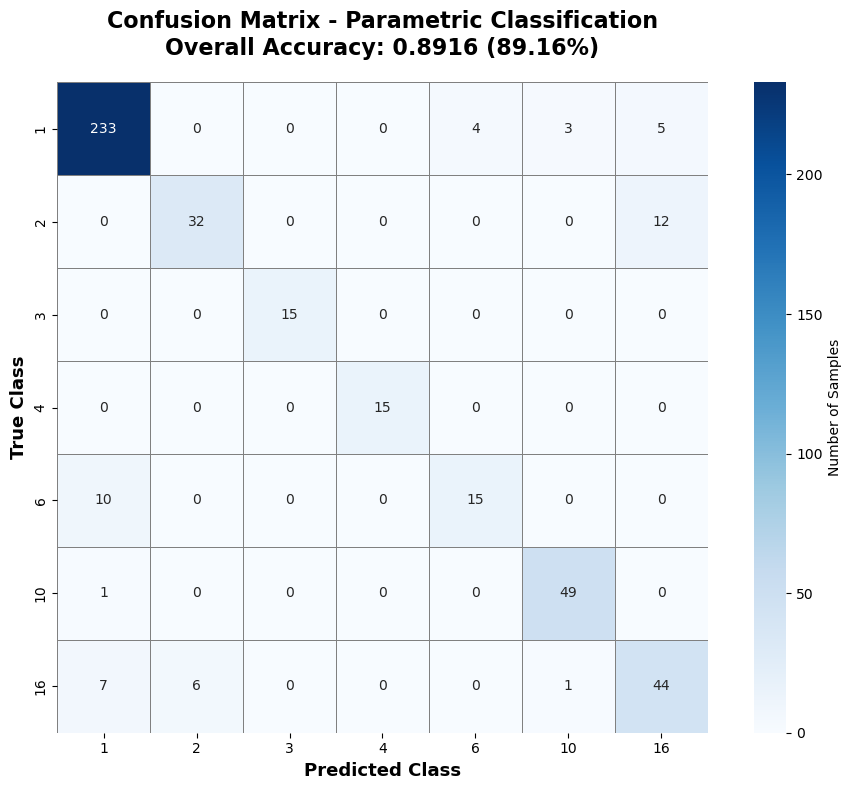


Class    Precision    Recall       Specificity  Accuracy    
--------------------------------------------------------------------------------
1        0.9283       0.9510       0.9130       0.9336      
2        0.8421       0.7273       0.9853       0.9602      
3        1.0000       1.0000       1.0000       1.0000      
4        1.0000       1.0000       1.0000       1.0000      
6        0.7895       0.6000       0.9906       0.9690      
10       0.9245       0.9800       0.9900       0.9889      
16       0.7213       0.7586       0.9569       0.9314      
--------------------------------------------------------------------------------
AVERAGE  0.8865       0.7586       0.9766       0.9690      


In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
unique_classes = sorted(np.unique(y))

plt.figure(figsize=(10, 8))

sns.heatmap(cm, 
            annot=True,     
            fmt='d',    
            cmap='Blues',         
            square=True,         
            cbar_kws={'label': 'Number of Samples'},
            xticklabels=unique_classes,
            yticklabels=unique_classes,
            linewidths=0.5,      
            linecolor='gray')

plt.title(f'Confusion Matrix - Parametric Classification\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'Class':<8} {'Precision':<12} {'Recall':<12} {'Specificity':<12} {'Accuracy':<12}")
print("-" * 80)

precision_list = []
sensitivity_list = []
specificity_list = []
accuracy_list = []

for idx, c in enumerate(unique_classes):
    TP = cm[idx, idx]
    FP = cm[:, idx].sum() - TP
    FN = cm[idx, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) else 0
    
    precision_list.append(precision)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    accuracy_list.append(accuracy)
    
    print(f"{c:<8d} {precision:<12.4f} {sensitivity:<12.4f} {specificity:<12.4f} {accuracy:<12.4f}")

print("-" * 80)
print(f"{'AVERAGE':<8} {np.mean(precision_list):<12.4f} {np.mean(sensitivity):<12.4f} "
      f"{np.mean(specificity_list):<12.4f} {np.mean(accuracy_list):<12.4f}")
print("=" * 80)